In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import dtw, soft_dtw

In [2]:
# 可視化メソッド
def plot_result(X_train, y_train, best_ind, km_li, name):
    plt.figure(figsize=(12,5))

    # true
    plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name} True')

    # pred
    plt.subplot(1,2,2)
    best_k = best_ind + 1
    best_km = km_li[best_ind]
    y_pred = best_km.predict(X_train) + 1

    label = np.unique(y_pred)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_pred == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.1)
        plt.plot(best_km.cluster_centers_[class_label - 1], label=f'Class {class_label}',
                color=colors[class_label - 1], linewidth=3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.title(f'{name} Pred')
    plt.tight_layout()
    plt.show()

In [33]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('Car')
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4]), array([16, 16, 11, 17]))

class4を正常データとして、それ以外を１個ずつピックする

In [34]:
X_train = np.concatenate(
            (X_train[y_train == 4],
            X_train[y_train == 1][0,np.newaxis],
            X_train[y_train == 2][0,np.newaxis],
            X_train[y_train == 3][0,np.newaxis],
            ))

y_train = np.concatenate(
            (y_train[y_train == 4],
            y_train[y_train == 1][0,np.newaxis],
            y_train[y_train == 2][0,np.newaxis],
            y_train[y_train == 3][0,np.newaxis],
            ))
y_train

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 3])

系列長を1/2にした

DBA k-means 1
	dist:  0.5199396021827534
DBA k-means 2
	dist:  0.33080342795143713
DBA k-means 3
	dist:  0.23925014684202367
DBA k-means 4
	dist:  0.20441932888219166
DBA k-means 5
	dist:  0.1878807930858814


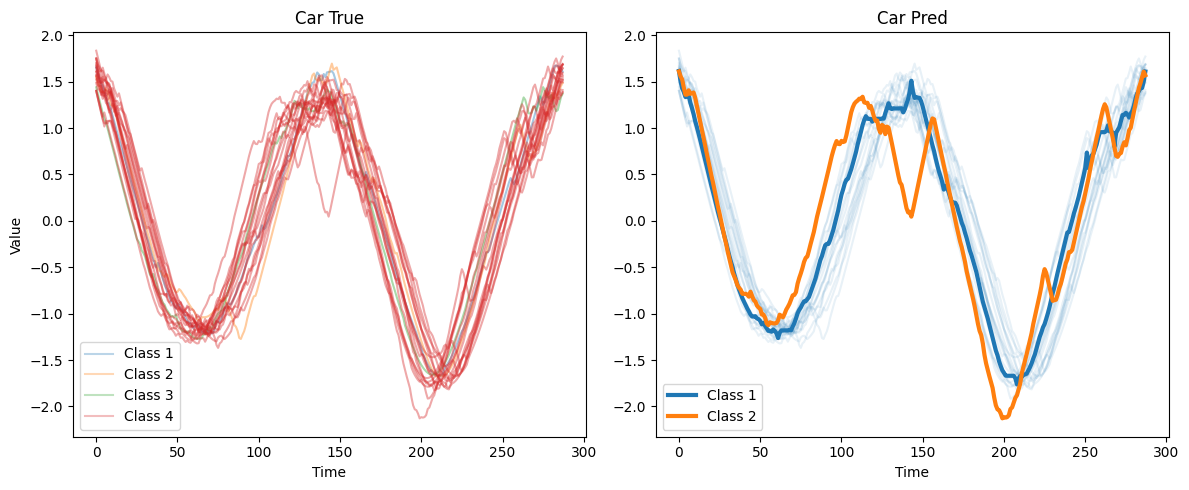

In [35]:
seed = 0
np.random.seed(seed)
name = 'Car'
# Keep only 50 time series

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
dist_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    dist_li.append(dba_km.inertia_)

    print('\tdist: ', dist_li[i])

dist_rate = [dist_li[i]/dist_li[i-1] for i in range(len(dist_li)) if i!=0]
best_ind = np.max([i for i, num in enumerate(dist_rate) if num < 0.7]) + 1

plot_result(X_train, y_train, best_ind, km_li, name)

In [39]:
km_li[best_ind].predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

class4の外れ値っぽいデータが、１クラスとして検出されてしまい、他のクラス由来の３点分のデータは他のクラス４データと同じクラスタとして認識されてしまった

そもそも、クラス1~3からピックしてきたデータが、クラス４に似ているものが多かったことも原因と予想される

データのピックを変えて、再チャレンジ

In [51]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('Car')
np.unique(y_train, return_counts=True)

X_train = np.concatenate(
            (X_train[y_train == 1],
            X_train[y_train == 4][0:5],
            X_train[y_train == 2][0:5],
            X_train[y_train == 3][0,np.newaxis],
            ))

y_train = np.concatenate(
            (y_train[y_train == 1],
            y_train[y_train == 4][0:5],
            y_train[y_train == 2][0:5],
            y_train[y_train == 3][0,np.newaxis],
            ))
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2,
       2, 2, 2, 2, 3])

DBA k-means 1
	dist:  0.3626472100664669
DBA k-means 2
	dist:  0.28824413979445845
DBA k-means 3
	dist:  0.24715013559215557
DBA k-means 4
	dist:  0.20691515235686084
DBA k-means 5
	dist:  0.1872534271211411


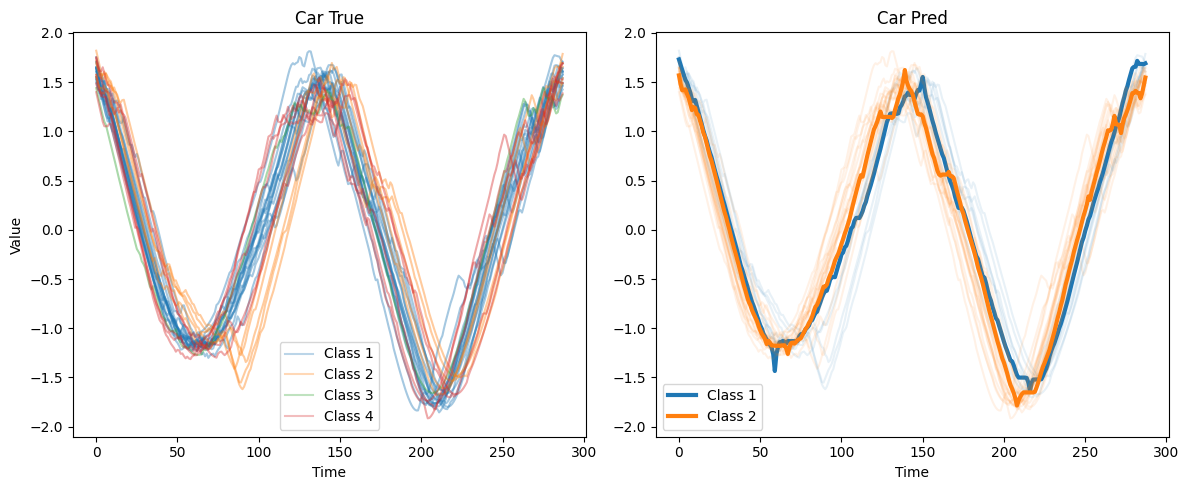

In [52]:
seed = 1
np.random.seed(seed)
name = 'Car'
# Keep only 50 time series

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
dist_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    dist_li.append(dba_km.inertia_)

    print('\tdist: ', dist_li[i])

dist_rate = [dist_li[i]/dist_li[i-1] for i in range(len(dist_li)) if i!=0]
best_ind = np.max([i for i, num in enumerate(dist_rate) if num < 0.8]) + 1

plot_result(X_train, y_train, best_ind, km_li, name)